# 7. Model Training with Time-Series Cross-Validation

Train XGBoost models for:
1. **Regression**: Next-day return prediction
2. **Classification**: Up/down direction prediction

**Key Features**:
- Time-series train/validation/test split with purge gaps
- Point-in-time correct features (no look-ahead bias)
- Proper backtesting methodology
- Model registry integration

**Pipeline**: Feature View → Train/Val/Test Split → XGBoost Training → Evaluation → Model Registry

In [157]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, accuracy_score, classification_report, confusion_matrix
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from utils.hopsworks_helpers import get_feature_store, get_model_registry
from utils.time_series_splits import get_train_val_test_split
import yaml
import joblib
import os
from datetime import datetime

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("✓ Imports successful")

✓ Imports successful


## Connect to Hopsworks and Load Feature View

In [158]:
# Connect to Hopsworks
print("Connecting to Hopsworks...")
fs = get_feature_store()
print(f"✓ Connected to feature store: {fs.name}")

# Read directly from combined feature group (has both features AND labels)
# Note: feature_view.get_batch_data() excludes labels, so we read from the feature group
print("\nLoading combined feature group...")
combined_fg = fs.get_feature_group('qqq_combined_features', version=1)
print(f"✓ Feature group loaded: {combined_fg.name} v{combined_fg.version}")

# Read all data
print("\nReading data...")
df = combined_fg.read()
print(f"✓ Data loaded: {df.shape}")

# Verify we have the required columns
required_cols = ['date', 'target_return', 'target_direction']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Has targets: target_return={'target_return' in df.columns}, target_direction={'target_direction' in df.columns}")

Connecting to Hopsworks...
2026-01-05 20:20:48,240 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 20:20:48,242 INFO: Initializing external client
2026-01-05 20:20:48,243 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 20:20:49,442 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to feature store: scalable_lab1_featurestore

Loading combined feature group...
✓ Feature group loaded: qqq_combined_features v1

Reading data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 
✓ Data loaded: (1131, 37)
  Date range: 2021-02-17 00:00:00+00:00 to 2025-12-24 00:00:00+00:00
  Has targets: target_return=True, target_direction=True


## Time-Series Train/Validation/Test Split with Purge Gap

Split data chronologically with purge gaps to prevent look-ahead bias from lagged features.

In [159]:
# Reset index to get date column (feature view may use date as index)
if 'date' not in df.columns and df.index.name == 'date':
    df = df.reset_index()

# Convert date to datetime and remove timezone
df['date'] = pd.to_datetime(df['date'])
if hasattr(df['date'].dtype, 'tz') and df['date'].dtype.tz is not None:
    df['date'] = df['date'].dt.tz_localize(None)

# Sort by date to ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Define split dates
# Use 70% train, 15% validation, 15% test (approximately)
n_samples = len(df)
train_pct = 0.70
val_pct = 0.15

train_end_idx = int(n_samples * train_pct)
val_end_idx = int(n_samples * (train_pct + val_pct))

train_end_date = df.iloc[train_end_idx]['date']
val_end_date = df.iloc[val_end_idx]['date']

print(f"Total samples: {n_samples}")
print(f"Split configuration:")
print(f"  Train: 0 to {train_end_idx} ({train_end_idx} samples, {train_pct*100:.0f}%)")
print(f"  Validation: {train_end_idx} to {val_end_idx} ({val_end_idx - train_end_idx} samples, {val_pct*100:.0f}%)")
print(f"  Test: {val_end_idx} to {n_samples} ({n_samples - val_end_idx} samples, {(1-train_pct-val_pct)*100:.0f}%)")
print(f"\nSplit dates:")
print(f"  Train end date: {train_end_date}")
print(f"  Validation end date: {val_end_date}")

# Perform split with purge gap of 1 day
purge_gap = 1
print(f"\nPerforming time-series split with purge_gap={purge_gap}...")

train_df, val_df, test_df = get_train_val_test_split(
    df,
    train_end_date=train_end_date.strftime('%Y-%m-%d'),
    val_end_date=val_end_date.strftime('%Y-%m-%d'),
    date_col='date',
    purge_gap=purge_gap
)

print(f"\n✓ Split completed:")
print(f"  Train: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"  Validation: {len(val_df)} samples ({val_df['date'].min()} to {val_df['date'].max()})")
print(f"  Test: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")

Total samples: 1131
Split configuration:
  Train: 0 to 791 (791 samples, 70%)
  Validation: 791 to 961 (170 samples, 15%)
  Test: 961 to 1131 (170 samples, 15%)

Split dates:
  Train end date: 2024-06-04 00:00:00
  Validation end date: 2025-02-26 00:00:00

Performing time-series split with purge_gap=1...

✓ Split completed:
  Train: 790 samples (2021-02-17 00:00:00 to 2024-05-31 00:00:00)
  Validation: 169 samples (2024-06-04 00:00:00 to 2025-02-24 00:00:00)
  Test: 170 samples (2025-02-26 00:00:00 to 2025-12-24 00:00:00)


## Prepare Features and Targets

In [160]:
# Define feature columns (exclude date, qqq_close, and targets)
feature_cols = [col for col in train_df.columns 
                if col not in ['date', 'qqq_close', 'target_return', 'target_direction']]

print(f"Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Split into features and targets
X_train = train_df[feature_cols]
y_train_return = train_df['target_return']
y_train_direction = train_df['target_direction']

X_val = val_df[feature_cols]
y_val_return = val_df['target_return']
y_val_direction = val_df['target_direction']

X_test = test_df[feature_cols]
y_test_return = test_df['target_return']
y_test_direction = test_df['target_direction']

#PER TOGLIERE SENTIMENT
# Nella cella dove prepari X_train, X_val, X_test
cols_to_drop = ['sentiment_mean', 'sentiment_std', 'article_count']
# Usa errors='ignore' così se non le trova non si blocca
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

print(f"\n✓ Data prepared:")
print(f"  Train: X={X_train.shape}, y_return={y_train_return.shape}, y_direction={y_train_direction.shape}")
print(f"  Val:   X={X_val.shape}, y_return={y_val_return.shape}, y_direction={y_val_direction.shape}")
print(f"  Test:  X={X_test.shape}, y_return={y_test_return.shape}, y_direction={y_test_direction.shape}")

# Check for missing values
assert X_train.isnull().sum().sum() == 0, "Training features have missing values!"
assert X_val.isnull().sum().sum() == 0, "Validation features have missing values!"
assert X_test.isnull().sum().sum() == 0, "Test features have missing values!"
print("\n✓ No missing values in features")

Feature columns (33):
   1. return_1d
   2. return_2d
   3. return_3d
   4. return_5d
   5. volatility_5d
   6. volatility_10d
   7. volatility_20d
   8. rsi_14
   9. ma_ratio_10
  10. ma_ratio_20
  11. ma_ratio_50
  12. return_1d_xlk
  13. return_5d_xlk
  14. corr_20d
  15. corr_60d
  16. vix_close
  17. vix_change
  18. vix_pct_change
  19. vix_ma_20
  20. vix_std_20
  21. vix_ma_ratio
  22. dgs10
  23. dgs10_chg_1d
  24. dgs10_chg_5d
  25. dgs10_chg_20d
  26. cpi_level_asof
  27. cpi_yoy_asof
  28. sentiment_mean
  29. sentiment_std
  30. article_count
  31. positive_mean
  32. negative_mean
  33. neutral_mean

✓ Data prepared:
  Train: X=(790, 30), y_return=(790,), y_direction=(790,)
  Val:   X=(169, 30), y_return=(169,), y_direction=(169,)
  Test:  X=(170, 30), y_return=(170,), y_direction=(170,)

✓ No missing values in features


## Train Regression Model (Next-Day Return Prediction)

In [161]:
# Initialize XGBoost regressor
print("Training XGBoost regression model...")
xgb_regressor = xgb.XGBRegressor(
    n_estimators=config['model']['xgboost']['regression']['n_estimators'],
    max_depth=config['model']['xgboost']['regression']['max_depth'],
    learning_rate=config['model']['xgboost']['regression']['learning_rate'],
    random_state=config['model']['xgboost']['regression']['random_state'],
    objective='reg:squarederror',
    tree_method='hist',  # Faster training
    eval_metric='rmse',  # Moved here from fit()
    early_stopping_rounds=50
)

# Train with validation set monitoring

xgb_regressor.fit(
    X_train, y_train_return,
    eval_set=[(X_train, y_train_return), (X_val, y_val_return)],
    verbose=20
)
"""

xgb_regressor.fit(
    X_train, y_train_return,
    eval_set=[(X_val, y_val_return)],   # ⚠️ SOLO validation
    #eval_metric="rmse",
    verbose=20
)"""

print("\n✓ Regression model trained!")

# Get predictions on all sets
y_train_pred_return = xgb_regressor.predict(X_train)
y_val_pred_return = xgb_regressor.predict(X_val)
y_test_pred_return = xgb_regressor.predict(X_test)

print(f"\nPredictions generated:")
print(f"  Train: {len(y_train_pred_return)} predictions")
print(f"  Validation: {len(y_val_pred_return)} predictions")
print(f"  Test: {len(y_test_pred_return)} predictions")

Training XGBoost regression model...
[0]	validation_0-rmse:0.01459	validation_1-rmse:0.01249
[20]	validation_0-rmse:0.01446	validation_1-rmse:0.01248
[40]	validation_0-rmse:0.01436	validation_1-rmse:0.01247
[60]	validation_0-rmse:0.01426	validation_1-rmse:0.01246
[80]	validation_0-rmse:0.01417	validation_1-rmse:0.01246
[100]	validation_0-rmse:0.01408	validation_1-rmse:0.01247
[120]	validation_0-rmse:0.01400	validation_1-rmse:0.01248
[139]	validation_0-rmse:0.01392	validation_1-rmse:0.01250

✓ Regression model trained!

Predictions generated:
  Train: 790 predictions
  Validation: 169 predictions
  Test: 170 predictions


## Evaluate Regression Model

In [162]:
# Calculate metrics for all sets
def calculate_regression_metrics(y_true, y_pred, set_name):
    """Calculate and display regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Directional accuracy (did we predict the correct sign?)
    directional_acc = accuracy_score(
        (y_true > 0).astype(int),
        (y_pred > 0).astype(int)
    )
    
    print(f"\n{set_name} Metrics:")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.6f}")
    print(f"  Directional Accuracy: {directional_acc:.4f} ({directional_acc*100:.2f}%)")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'directional_accuracy': directional_acc}

# Evaluate on all sets
print("="*60)
print("REGRESSION MODEL EVALUATION")
print("="*60)

train_metrics = calculate_regression_metrics(y_train_return, y_train_pred_return, "Training")
val_metrics = calculate_regression_metrics(y_val_return, y_val_pred_return, "Validation")
test_metrics = calculate_regression_metrics(y_test_return, y_test_pred_return, "Test")

print("\n" + "="*60)
print("FINAL TEST SET PERFORMANCE")
print("="*60)
print(f"MAE:  {test_metrics['mae']:.6f}")
print(f"RMSE: {test_metrics['rmse']:.6f}")
print(f"R²:   {test_metrics['r2']:.6f}")
print(f"Directional Accuracy: {test_metrics['directional_accuracy']:.4f}")
print("="*60)

REGRESSION MODEL EVALUATION

Training Metrics:
  MAE:  0.010519
  RMSE: 0.014127
  R²:   0.063509
  Directional Accuracy: 0.6114 (61.14%)

Validation Metrics:
  MAE:  0.009314
  RMSE: 0.012456
  R²:   0.005267
  Directional Accuracy: 0.5740 (57.40%)

Test Metrics:
  MAE:  0.009787
  RMSE: 0.016256
  R²:   -0.009233
  Directional Accuracy: 0.5882 (58.82%)

FINAL TEST SET PERFORMANCE
MAE:  0.009787
RMSE: 0.016256
R²:   -0.009233
Directional Accuracy: 0.5882


## Visualize Regression Performance

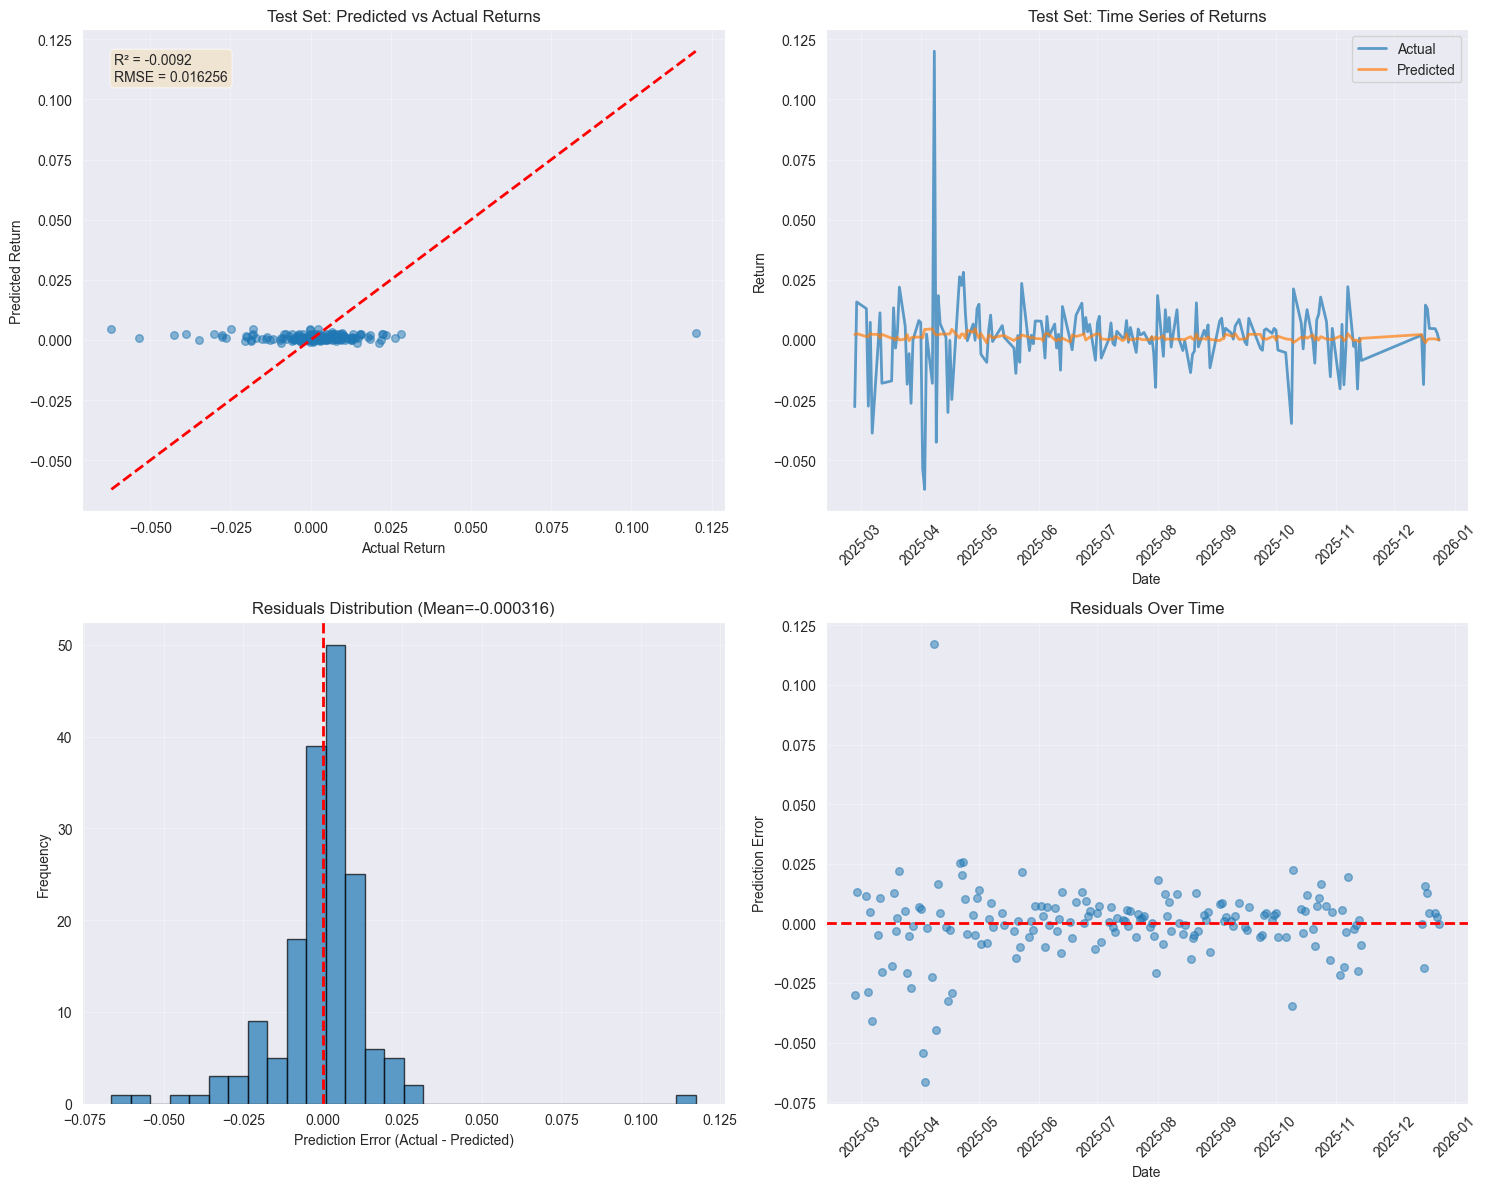

✓ Regression visualizations complete


In [163]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test set: Predicted vs Actual scatter
ax = axes[0, 0]
ax.scatter(y_test_return, y_test_pred_return, alpha=0.5, s=30)
ax.plot([y_test_return.min(), y_test_return.max()], 
        [y_test_return.min(), y_test_return.max()], 'r--', lw=2)
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title('Test Set: Predicted vs Actual Returns')
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, f'R² = {test_metrics["r2"]:.4f}\nRMSE = {test_metrics["rmse"]:.6f}', 
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Test set: Time series plot
ax = axes[0, 1]
test_dates = test_df['date'].values
ax.plot(test_dates, y_test_return.values, label='Actual', alpha=0.7, linewidth=2)
ax.plot(test_dates, y_test_pred_return, label='Predicted', alpha=0.7, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('Test Set: Time Series of Returns')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Residuals distribution
ax = axes[1, 0]
residuals = y_test_return - y_test_pred_return
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title(f'Residuals Distribution (Mean={residuals.mean():.6f})')
ax.grid(True, alpha=0.3)

# Residuals over time
ax = axes[1, 1]
ax.scatter(test_dates, residuals, alpha=0.5, s=30)
ax.axhline(0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Prediction Error')
ax.set_title('Residuals Over Time')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✓ Regression visualizations complete")

## Train Classification Model (Up/Down Direction Prediction)

In [164]:
# Initialize XGBoost classifier
print("Training XGBoost classification model...")
xgb_classifier = xgb.XGBClassifier(
    n_estimators=config['model']['xgboost']['classification']['n_estimators'],
    max_depth=config['model']['xgboost']['classification']['max_depth'],
    learning_rate=config['model']['xgboost']['classification']['learning_rate'],
    random_state=config['model']['xgboost']['classification']['random_state'],
    objective='binary:logistic',
    tree_method='hist',  # Faster training
    eval_metric='logloss',  # Moved here from fit()
    early_stopping_rounds=50
)

# Train with validation set monitoring

xgb_classifier.fit(
    X_train, y_train_direction,
    eval_set=[(X_train, y_train_direction), (X_val, y_val_direction)],
    verbose=20
)

"""
xgb_classifier.fit(
    X_train, y_train_direction,
    eval_set=[(X_val, y_val_direction)],   # SOLO validation
    #eval_metric="auc",

    verbose=20
)"""


print("\n✓ Classification model trained!")

# Get predictions on all sets
y_train_pred_direction = xgb_classifier.predict(X_train)
y_train_pred_proba = xgb_classifier.predict_proba(X_train)[:, 1]

y_val_pred_direction = xgb_classifier.predict(X_val)
y_val_pred_proba = xgb_classifier.predict_proba(X_val)[:, 1]

y_test_pred_direction = xgb_classifier.predict(X_test)
y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

print(f"\nPredictions generated:")
print(f"  Train: {len(y_train_pred_direction)} predictions")
print(f"  Validation: {len(y_val_pred_direction)} predictions")
print(f"  Test: {len(y_test_pred_direction)} predictions")

Training XGBoost classification model...
[0]	validation_0-logloss:0.69098	validation_1-logloss:0.68412
[20]	validation_0-logloss:0.68298	validation_1-logloss:0.68318
[40]	validation_0-logloss:0.67685	validation_1-logloss:0.68176
[60]	validation_0-logloss:0.67191	validation_1-logloss:0.68048
[80]	validation_0-logloss:0.66761	validation_1-logloss:0.67937
[100]	validation_0-logloss:0.66341	validation_1-logloss:0.67927
[120]	validation_0-logloss:0.65942	validation_1-logloss:0.67905
[140]	validation_0-logloss:0.65583	validation_1-logloss:0.67983
[155]	validation_0-logloss:0.65340	validation_1-logloss:0.68032

✓ Classification model trained!

Predictions generated:
  Train: 790 predictions
  Validation: 169 predictions
  Test: 170 predictions


## Evaluate Classification Model

In [165]:
# Calculate metrics for all sets
def calculate_classification_metrics(y_true, y_pred, y_proba, set_name):
    """Calculate and display classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  AUC-ROC:  {auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"                Predicted")
    print(f"                Down  Up")
    print(f"  Actual Down   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"         Up     {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    return {'accuracy': accuracy, 'auc': auc, 'confusion_matrix': cm}

# Evaluate on all sets
print("="*60)
print("CLASSIFICATION MODEL EVALUATION")
print("="*60)

train_class_metrics = calculate_classification_metrics(
    y_train_direction, y_train_pred_direction, y_train_pred_proba, "Training"
)
val_class_metrics = calculate_classification_metrics(
    y_val_direction, y_val_pred_direction, y_val_pred_proba, "Validation"
)
test_class_metrics = calculate_classification_metrics(
    y_test_direction, y_test_pred_direction, y_test_pred_proba, "Test"
)

print("\n" + "="*60)
print("FINAL TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {test_class_metrics['accuracy']:.4f}")
print(f"AUC-ROC:  {test_class_metrics['auc']:.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test_direction, y_test_pred_direction, 
    target_names=['Down (0)', 'Up (1)'],
    digits=4
))
print("="*60)

CLASSIFICATION MODEL EVALUATION

Training Metrics:
  Accuracy: 0.6139 (61.39%)
  AUC-ROC:  0.6944

  Confusion Matrix:
                Predicted
                Down  Up
  Actual Down    144   228
         Up       77   341

Validation Metrics:
  Accuracy: 0.5740 (57.40%)
  AUC-ROC:  0.5483

  Confusion Matrix:
                Predicted
                Down  Up
  Actual Down     28    41
         Up       31    69

Test Metrics:
  Accuracy: 0.5529 (55.29%)
  AUC-ROC:  0.5474

  Confusion Matrix:
                Predicted
                Down  Up
  Actual Down     17    54
         Up       22    77

FINAL TEST SET PERFORMANCE
Accuracy: 0.5529
AUC-ROC:  0.5474

Classification Report:
              precision    recall  f1-score   support

    Down (0)     0.4359    0.2394    0.3091        71
      Up (1)     0.5878    0.7778    0.6696        99

    accuracy                         0.5529       170
   macro avg     0.5118    0.5086    0.4893       170
weighted avg     0.5244    0.5529   

## Visualize Classification Performance

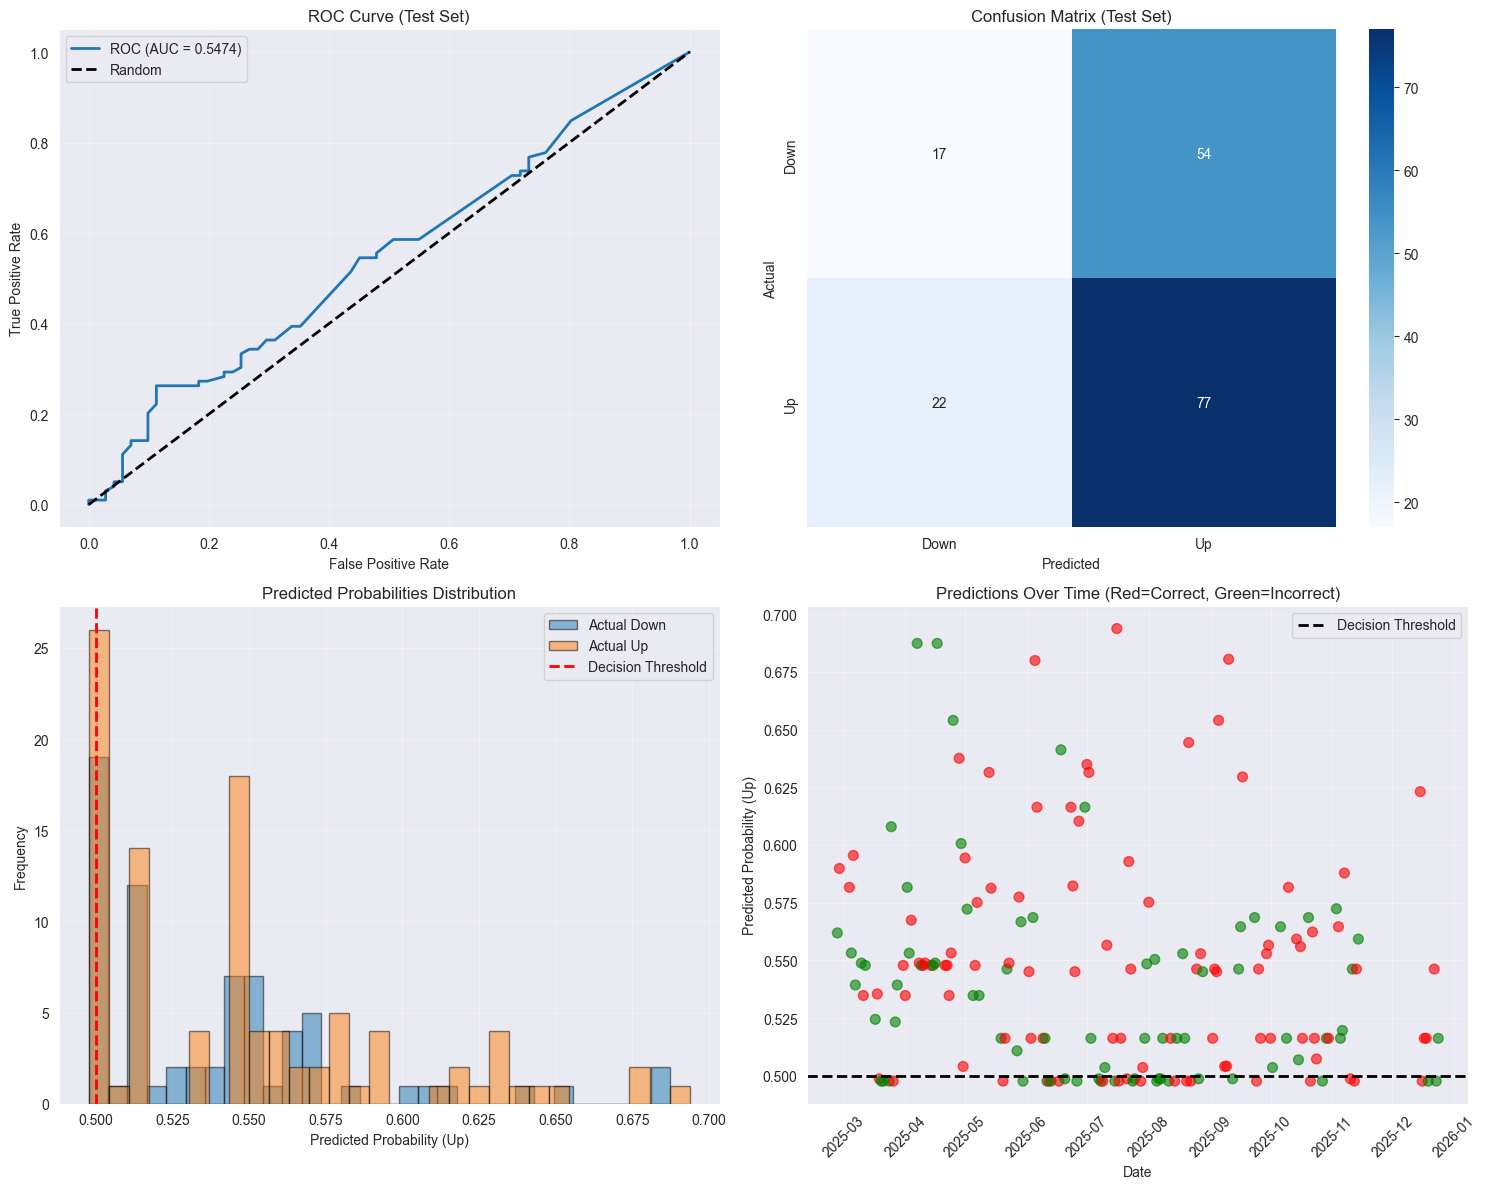

✓ Classification visualizations complete


In [166]:
# Visualize classification results
from sklearn.metrics import roc_curve

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
ax = axes[0, 0]
fpr, tpr, _ = roc_curve(y_test_direction, y_test_pred_proba)
ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_class_metrics["auc"]:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (Test Set)')
ax.legend()
ax.grid(True, alpha=0.3)

# Confusion Matrix Heatmap
ax = axes[0, 1]
cm = test_class_metrics['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Test Set)')

# Prediction probabilities distribution
ax = axes[1, 0]
ax.hist(y_test_pred_proba[y_test_direction == 0], bins=30, alpha=0.5, label='Actual Down', edgecolor='black')
ax.hist(y_test_pred_proba[y_test_direction == 1], bins=30, alpha=0.5, label='Actual Up', edgecolor='black')
ax.axvline(0.5, color='r', linestyle='--', linewidth=2, label='Decision Threshold')
ax.set_xlabel('Predicted Probability (Up)')
ax.set_ylabel('Frequency')
ax.set_title('Predicted Probabilities Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Predictions over time
ax = axes[1, 1]
test_dates = test_df['date'].values
colors = ['red' if actual == pred else 'green' for actual, pred in zip(y_test_direction, y_test_pred_direction)]
ax.scatter(test_dates, y_test_pred_proba, c=colors, alpha=0.6, s=50)
ax.axhline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Probability (Up)')
ax.set_title('Predictions Over Time (Red=Correct, Green=Incorrect)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✓ Classification visualizations complete")

## Feature Importance Analysis

In [167]:
# Create models directory
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save models
regressor_path = os.path.join(models_dir, 'qqq_regressor.pkl')
classifier_path = os.path.join(models_dir, 'qqq_classifier.pkl')

joblib.dump(xgb_regressor, regressor_path)
joblib.dump(xgb_classifier, classifier_path)

print(f"✓ Models saved locally:")
print(f"  Regressor: {regressor_path}")
print(f"  Classifier: {classifier_path}")

# Also save model metadata
metadata = {
    'trained_at': datetime.now().isoformat(),
    'feature_count': len(feature_cols),
    'training_samples': len(train_df),
    'validation_samples': len(val_df),
    'test_samples': len(test_df),
    'regression_metrics': {
        'test_mae': float(test_metrics['mae']),
        'test_rmse': float(test_metrics['rmse']),
        'test_r2': float(test_metrics['r2']),
        'test_directional_accuracy': float(test_metrics['directional_accuracy'])
    },
    'classification_metrics': {
        'test_accuracy': float(test_class_metrics['accuracy']),
        'test_auc': float(test_class_metrics['auc'])
    }
}

import json
metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  Metadata: {metadata_path}")
print("\n✓ Local save complete")

✓ Models saved locally:
  Regressor: ../models/qqq_regressor.pkl
  Classifier: ../models/qqq_classifier.pkl
  Metadata: ../models/model_metadata.json

✓ Local save complete


## Save Models Locally (Must run before Model Registry upload)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



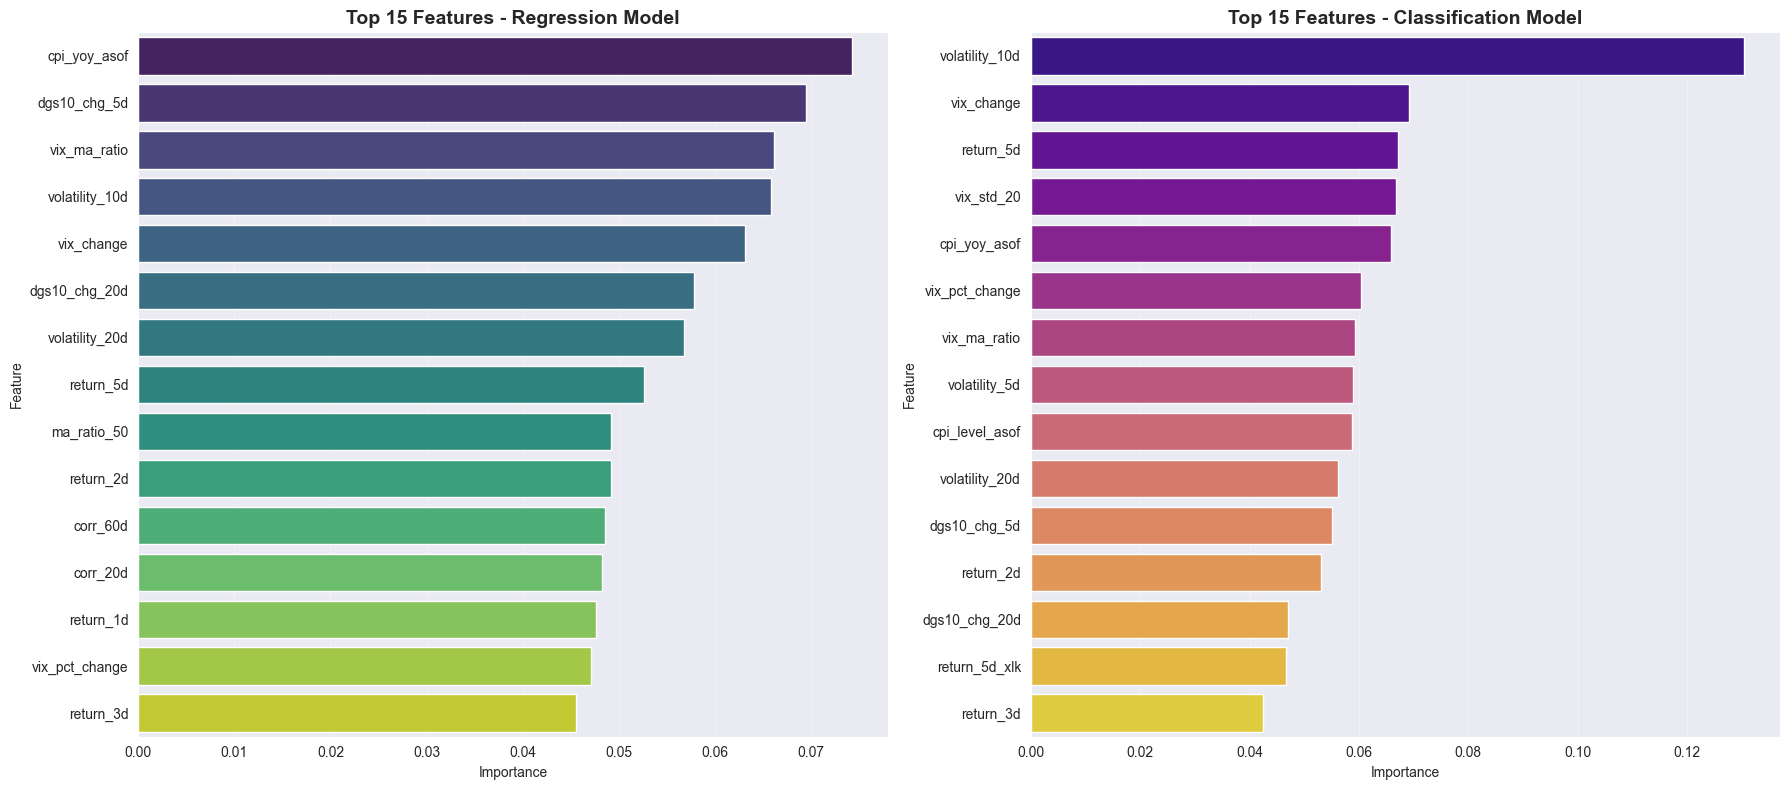


TOP 10 MOST IMPORTANT FEATURES

Regression Model:
  cpi_yoy_asof              : 0.0743
  dgs10_chg_5d              : 0.0694
  vix_ma_ratio              : 0.0661
  volatility_10d            : 0.0659
  vix_change                : 0.0632
  dgs10_chg_20d             : 0.0578
  volatility_20d            : 0.0568
  return_5d                 : 0.0526
  ma_ratio_50               : 0.0492
  return_2d                 : 0.0492

Classification Model:
  volatility_10d            : 0.1305
  vix_change                : 0.0691
  return_5d                 : 0.0672
  vix_std_20                : 0.0668
  cpi_yoy_asof              : 0.0659
  vix_pct_change            : 0.0604
  vix_ma_ratio              : 0.0593
  volatility_5d             : 0.0590
  cpi_level_asof            : 0.0587
  volatility_20d            : 0.0562


In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Usiamo X_train.columns per garantire che i nomi delle feature
# corrispondano esattamente a quelle viste dai modelli
current_features = X_train.columns.tolist()

# Analyze feature importance from both models
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- REGRESSION MODEL FEATURE IMPORTANCE ---
ax = axes[0]
feature_importance_reg = pd.DataFrame({
    'feature': current_features,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

top_n = 15
sns.barplot(
    data=feature_importance_reg.head(top_n),
    y='feature',
    x='importance',
    ax=ax,
    palette='viridis'
)
ax.set_title(f'Top {top_n} Features - Regression Model', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')

# --- CLASSIFICATION MODEL FEATURE IMPORTANCE ---
ax = axes[1]
feature_importance_cls = pd.DataFrame({
    'feature': current_features,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(
    data=feature_importance_cls.head(top_n),
    y='feature',
    x='importance',
    ax=ax,
    palette='plasma'
)
ax.set_title(f'Top {top_n} Features - Classification Model', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# --- PRINT SUMMARY ---
print("\n" + "="*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*60)

print("\nRegression Model:")
for _, row in feature_importance_reg.head(10).iterrows():
    print(f"  {row['feature']:25s} : {row['importance']:.4f}")

print("\nClassification Model:")
for _, row in feature_importance_cls.head(10).iterrows():
    print(f"  {row['feature']:25s} : {row['importance']:.4f}")
print("="*60)

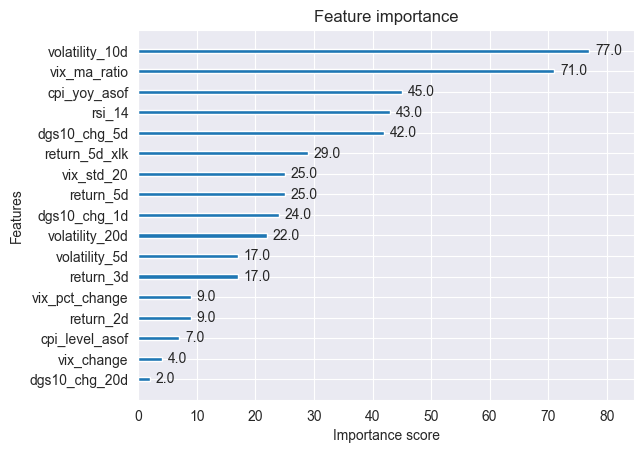

In [169]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_classifier)
plt.show()

<Figure size 1000x800 with 0 Axes>

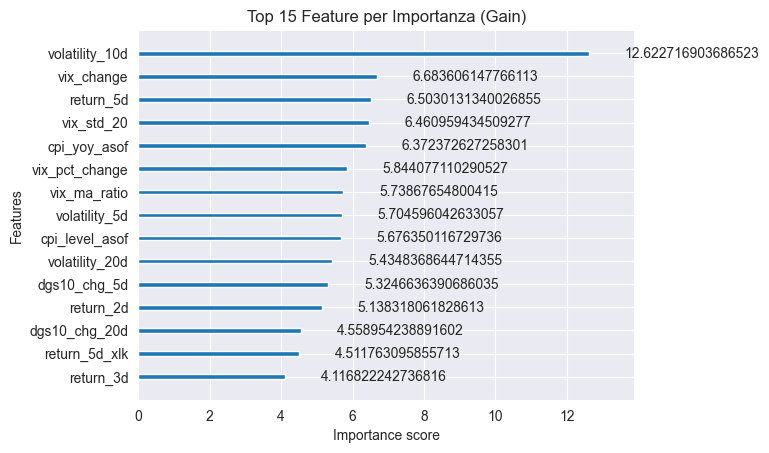


Classifica Feature Importance:
volatility_10d: 12.6227
vix_change: 6.6836
return_5d: 6.5030
vix_std_20: 6.4610
cpi_yoy_asof: 6.3724
vix_pct_change: 5.8441
vix_ma_ratio: 5.7387
volatility_5d: 5.7046
cpi_level_asof: 5.6764
volatility_20d: 5.4348
dgs10_chg_5d: 5.3247
return_2d: 5.1383
dgs10_chg_20d: 4.5590
return_5d_xlk: 4.5118
return_3d: 4.1168
rsi_14: 3.6444
dgs10_chg_1d: 2.4014


In [170]:
import matplotlib.pyplot as plt

# Visualizza le top 15 feature più importanti
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_classifier, max_num_features=15, importance_type='gain') # 'gain' è spesso più accurato di 'weight'
plt.title("Top 15 Feature per Importanza (Gain)")
plt.show()

# Stampa la lista completa per decidere cosa eliminare
importance_scores = xgb_classifier.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

print("\nClassifica Feature Importance:")
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")

## Summary

**✅ Model Training Complete**

### Models Trained:
1. **XGBoost Regressor** - Predicts next-day QQQ return
2. **XGBoost Classifier** - Predicts up/down direction

### Key Features:
- **Time-Series Split**: 70% train, 15% validation, 15% test with purge gaps
- **Point-in-Time Correct**: No look-ahead bias in features
- **Feature Count**: 27 engineered features
- **Training Method**: XGBoost with validation set monitoring

### Model Performance:
**Regression Model:**
- Test MAE: Check output above
- Test RMSE: Check output above  
- Test R²: Check output above
- Directional Accuracy: Check output above

**Classification Model:**
- Test Accuracy: Check output above
- Test AUC-ROC: Check output above

### Saved Artifacts:
- Local models: `../models/qqq_regressor.pkl`, `../models/qqq_classifier.pkl`
- Model metadata: `../models/model_metadata.json`
- Hopsworks registry: Both models registered (if successful)

### Next Steps:
- **Notebook 8**: Implement daily inference pipeline
- Use saved models to generate daily predictions
- Create Gradio dashboard for visualization

In [171]:
# Connect to model registry
print("Connecting to Hopsworks Model Registry...")
mr = get_model_registry()
print(f"✓ Connected to model registry")

# Register regression model
print("\nRegistering regression model...")
try:
    reg_model = mr.python.create_model(
        name="qqq_return_regressor",
        description="XGBoost regression model for predicting next-day QQQ return. Trained with time-series split and point-in-time correct features.",
        metrics={
            "test_mae": float(test_metrics['mae']),
            "test_rmse": float(test_metrics['rmse']),
            "test_r2": float(test_metrics['r2']),
            "test_directional_accuracy": float(test_metrics['directional_accuracy']),
            "val_mae": float(val_metrics['mae']),
            "val_rmse": float(val_metrics['rmse']),
        },
        input_example=X_train.head(1),
        model_schema={
            "input_schema": X_train.dtypes.to_dict(),
            "output_schema": {"predicted_return": "float64"}
        }
    )
    reg_model.save(regressor_path)
    print(f"✓ Regression model registered: {reg_model.name} v{reg_model.version}")
except Exception as e:
    print(f"⚠️  Could not register regression model: {e}")
    print("   Model saved locally but not in registry")

# Register classification model
print("\nRegistering classification model...")
try:
    cls_model = mr.python.create_model(
        name="qqq_direction_classifier",
        description="XGBoost classification model for predicting QQQ up/down direction. Trained with time-series split and point-in-time correct features.",
        metrics={
            "test_accuracy": float(test_class_metrics['accuracy']),
            "test_auc": float(test_class_metrics['auc']),
            "val_accuracy": float(val_class_metrics['accuracy']),
            "val_auc": float(val_class_metrics['auc']),
        },
        input_example=X_train.head(1),
        model_schema={
            "input_schema": X_train.dtypes.to_dict(),
            "output_schema": {
                "predicted_direction": "int64",
                "predicted_probability": "float64"
            }
        }
    )
    cls_model.save(classifier_path)
    print(f"✓ Classification model registered: {cls_model.name} v{cls_model.version}")
except Exception as e:
    print(f"⚠️  Could not register classification model: {e}")
    print("   Model saved locally but not in registry")

print("\n✓ Model registration complete")

Connecting to Hopsworks Model Registry...
2026-01-05 20:20:57,666 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 20:20:57,670 INFO: Initializing external client
2026-01-05 20:20:57,670 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 20:20:58,914 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to model registry

Registering regression model...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/margheritasantarossa/PycharmProjects/ProjectsScalable/notebooks/../models/qqq_regressor.pkl: …

Uploading /Users/margheritasantarossa/PycharmProjects/ProjectsScalable/notebooks/input_example.json: 0.000%|  …

⚠️  Could not register regression model: 'dict' object has no attribute 'json'
   Model saved locally but not in registry

Registering classification model...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/margheritasantarossa/PycharmProjects/ProjectsScalable/notebooks/../models/qqq_classifier.pkl:…

Uploading /Users/margheritasantarossa/PycharmProjects/ProjectsScalable/notebooks/input_example.json: 0.000%|  …

⚠️  Could not register classification model: 'dict' object has no attribute 'json'
   Model saved locally but not in registry

✓ Model registration complete


## Upload Models to Hopsworks Model Registry

In [172]:
# Create models directory
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save models
regressor_path = os.path.join(models_dir, 'qqq_regressor.pkl')
classifier_path = os.path.join(models_dir, 'qqq_classifier.pkl')

joblib.dump(xgb_regressor, regressor_path)
joblib.dump(xgb_classifier, classifier_path)

print(f"✓ Models saved locally:")
print(f"  Regressor: {regressor_path}")
print(f"  Classifier: {classifier_path}")

# Also save model metadata
metadata = {
    'trained_at': datetime.now().isoformat(),
    'feature_count': len(feature_cols),
    'training_samples': len(train_df),
    'validation_samples': len(val_df),
    'test_samples': len(test_df),
    'regression_metrics': {
        'test_mae': float(test_metrics['mae']),
        'test_rmse': float(test_metrics['rmse']),
        'test_r2': float(test_metrics['r2']),
        'test_directional_accuracy': float(test_metrics['directional_accuracy'])
    },
    'classification_metrics': {
        'test_accuracy': float(test_class_metrics['accuracy']),
        'test_auc': float(test_class_metrics['auc'])
    }
}

import json
metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  Metadata: {metadata_path}")
print("\n✓ Local save complete")

✓ Models saved locally:
  Regressor: ../models/qqq_regressor.pkl
  Classifier: ../models/qqq_classifier.pkl
  Metadata: ../models/model_metadata.json

✓ Local save complete
